In [9]:
%load_ext autoreload
%autoreload 2
from IPython.display import SVG, display, Image

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from tensorflow import keras

import tsgm


def plot(timesteps, X, plot_id=1, title="Original"):
    plt.subplot(1, 2, plot_id)
    for sample_id in range(X.shape[0]):
        plt.plot(timesteps, X[sample_id, :, 0], label=f"Sample #{sample_id}")
    plt.title(title)
    plt.legend()


def plot_samples_aug(X, Xaug, n_samples=5):
    timesteps = np.arange(0, X.shape[1], 1)
    sample_ids = random.sample(range(X.shape[0]), n_samples)
    sample_ids_aug = random.sample(range(Xaug.shape[0]), n_samples)

    plot(timesteps, X[sample_ids])
    plot(timesteps, Xaug[sample_ids_aug], title="Augmented", plot_id=2)
    plt.show()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
X = tsgm.utils.gen_sine_dataset(100, 64, 2, max_value=20)

In [11]:
aug_model = tsgm.models.augmentations.GaussianNoise()
samples = aug_model.generate(X=X, n_samples=10, variance=0.2)

##Jitter/Gaussian Noise##

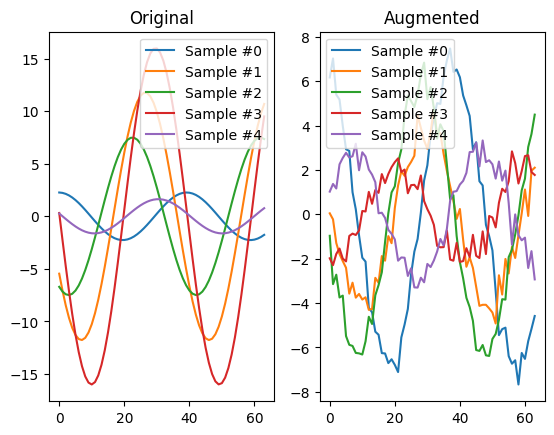

In [12]:
plot_samples_aug(X, samples)

##Shuffle Features##

In [13]:
aug_model = tsgm.models.augmentations.Shuffle()
samples = aug_model.generate(X=X, n_samples=3)

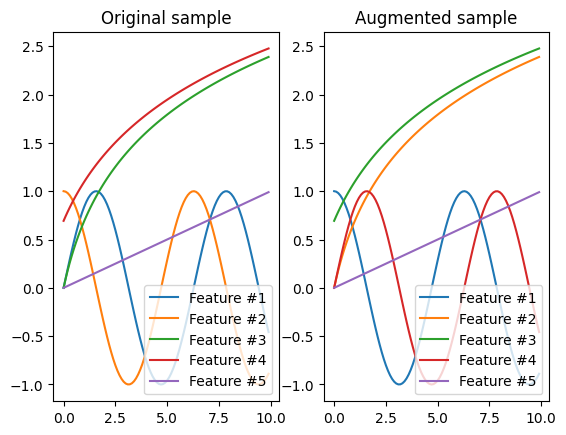

In [14]:
timesteps = np.arange(0, 10, 0.1)
sample = np.stack([np.sin(timesteps), np.cos(timesteps), np.log(timesteps + 1), np.log(timesteps + 2), timesteps / 10])
plt.subplot(1, 2, 1)
for feature_id in range(5):
    plt.plot(timesteps, sample[feature_id], label=f"Feature #{feature_id + 1}")
plt.title("Original sample")
plt.legend()

permutation = [1, 2, 3, 0, 4]
sample = sample[permutation]
plt.subplot(1, 2, 2)
for feature_id in range(5):
    plt.plot(timesteps, sample[feature_id], label=f"Feature #{feature_id + 1}")
plt.title("Augmented sample")
plt.legend()
plt.show()

##Slice and Shuffle

In [15]:
aug_model = tsgm.models.augmentations.SliceAndShuffle()
samples = aug_model.generate(X=X, n_samples=10, n_segments=3)

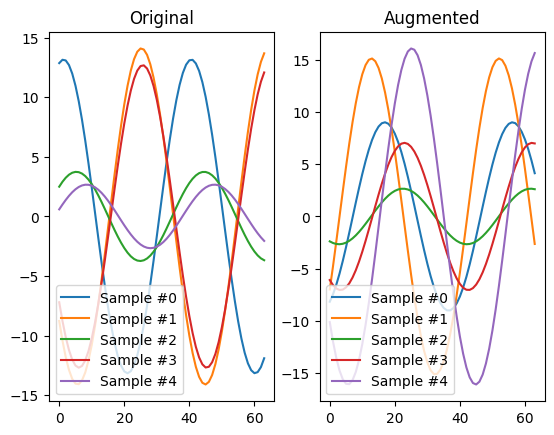

In [16]:
plot_samples_aug(X, samples)

##Magnitude Warping

In [17]:
aug_model = tsgm.models.augmentations.MagnitudeWarping()
samples = aug_model.generate(X=X, n_samples=10, sigma=1)

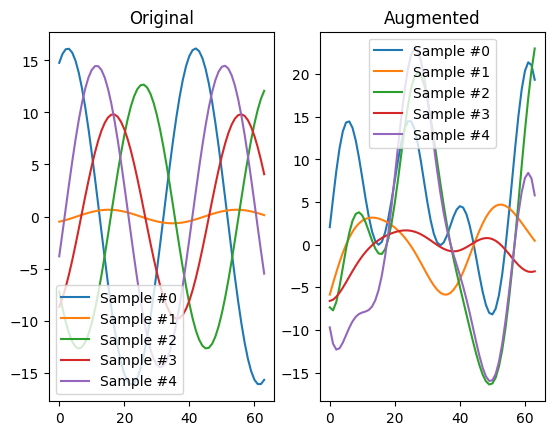

In [18]:
plot_samples_aug(X, samples)

##Window Warping##

In [19]:
aug_model = tsgm.models.augmentations.WindowWarping()
samples = aug_model.generate(X=X, n_samples=10, scales=(0.5,), window_ratio=0.5)

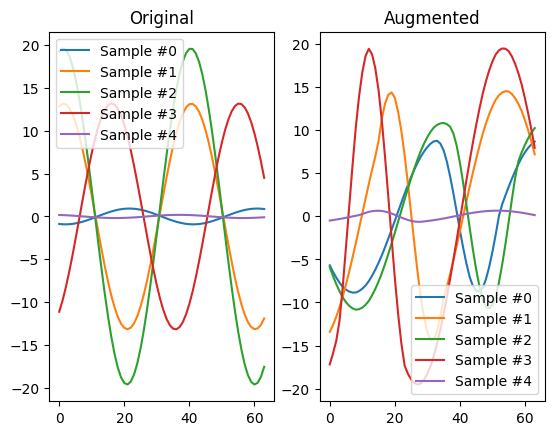

In [20]:
plot_samples_aug(X, samples)

##Dynamic Time Warping Barycentric Average (DTWBA)

In [21]:
aug_model = tsgm.models.augmentations.DTWBarycentricAveraging()
initial_timeseries = random.sample(range(X.shape[0]), 10)
initial_timeseries = X[initial_timeseries]
samples = aug_model.generate(X=X, n_samples=10, initial_timeseries=initial_timeseries )

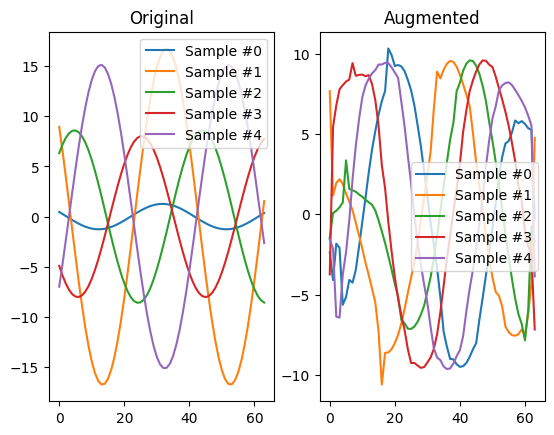

In [22]:
plot_samples_aug(X, samples)

##Generative ML model

In [23]:
n, n_ts, n_features  = 1000, 24, 5
data = tsgm.utils.gen_sine_dataset(n, n_ts, n_features)
scaler = tsgm.utils.TSFeatureWiseScaler()
scaled_data = scaler.fit_transform(data)
architecture = tsgm.models.zoo["vae_conv5"](n_ts, n_features, 10)
encoder, decoder = architecture.encoder, architecture.decoder
vae = tsgm.models.cvae.BetaVAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(scaled_data, epochs=1, batch_size=64)
samples = vae.generate(10)

16/16 [==============================] - 8s 172ms/step - loss: 318.0705 - reconstruction_loss: 312.8858 - kl_loss: 2.2200


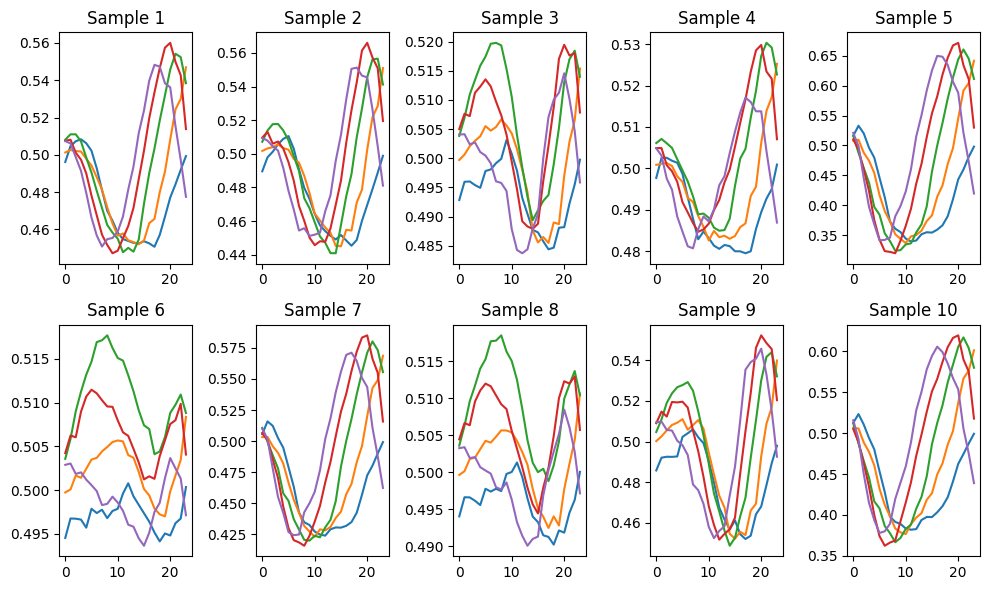

In [27]:
# Plot the VAE-generated samples
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.plot(samples[i])
    plt.title(f'Sample {i+1}')
plt.tight_layout()
plt.show()

##Using GANs##

In [26]:
import numpy as np
from keras.layers import Dense, Reshape, Flatten
from keras.models import Sequential
from keras.optimizers import Adam

# Define the dimensions
n, n_ts, n_features = 1000, 24, 5

# Generate synthetic data
data = tsgm.utils.gen_sine_dataset(n, n_ts, n_features)

# Define your GAN architecture
def build_generator():
    generator = Sequential()
    generator.add(Dense(128, input_dim=100, activation='relu'))
    generator.add(Dense(n_ts * n_features, activation='tanh'))
    generator.add(Reshape((n_ts, n_features)))
    return generator

def build_discriminator():
    discriminator = Sequential()
    discriminator.add(Flatten(input_shape=(n_ts, n_features)))
    discriminator.add(Dense(128, activation='relu'))
    discriminator.add(Dense(1, activation='sigmoid'))
    return discriminator

generator = build_generator()
discriminator = build_discriminator()

# Define the GAN model
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
discriminator.trainable = False

gan_input = keras.Input(shape=(100,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = keras.models.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Train the GAN
batch_size = 64
epochs = 1000

for e in range(epochs):
    for _ in range(n // batch_size):
        noise = np.random.normal(0, 1, size=[batch_size, 100])
        generated_data = generator.predict(noise)
        real_data = data[np.random.randint(0, data.shape[0], batch_size)]
        data_batch = np.concatenate([real_data, generated_data])
        labels = np.zeros(2 * batch_size)
        labels[:batch_size] = 1

        d_loss = discriminator.train_on_batch(data_batch, labels)

        noise = np.random.normal(0, 1, size=[batch_size, 100])
        labels = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, labels)

    if e % 10 == 0:
        print(f"Epoch {e}, D Loss: {d_loss}, G Loss: {g_loss}")

# Generate samples
num_samples = 10
noise = np.random.normal(0, 1, size=[num_samples, 100])
generated_samples = generator.predict(noise)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 6ms/step
Epoch 670, D Loss: 0.19263526797294617, G Loss: 2.4106764793395996
2/2 [==============================] - 0s 4ms/step
Epoch 680, D Loss: 0.22143760323524475, G Loss: 2.2345991134643555
2/2 [==============================] - 0s 7ms/step
Epoch 690, D Loss: 0.15610121190547943, G Loss: 2.3417608737945557
2/2 [==============================] - 0s 7ms/step
Epoch 700, D Loss: 0.22420525550842285, G Loss: 2.2027926445007324
2/2 [==============================] - 0s 12ms/step
Epoch 710, D Loss: 0.17027291655540466, G Loss: 2.4163241386413574
2/2 [==============================] - 0s 7ms/step
Epoch 720, D Loss: 0.1994669884443283, G Loss: 2.2520930767059326
2/2 [==============================] - 0s 8ms/step
Epoch 730, D Loss: 0.1402510553598404, G Loss: 2.381284713745117
2/2 [==============================] - 0s 5ms/step
Epoch 740, D Loss: 0.2140423208475113, G Loss: 2.2427990436553955
2/2 [===

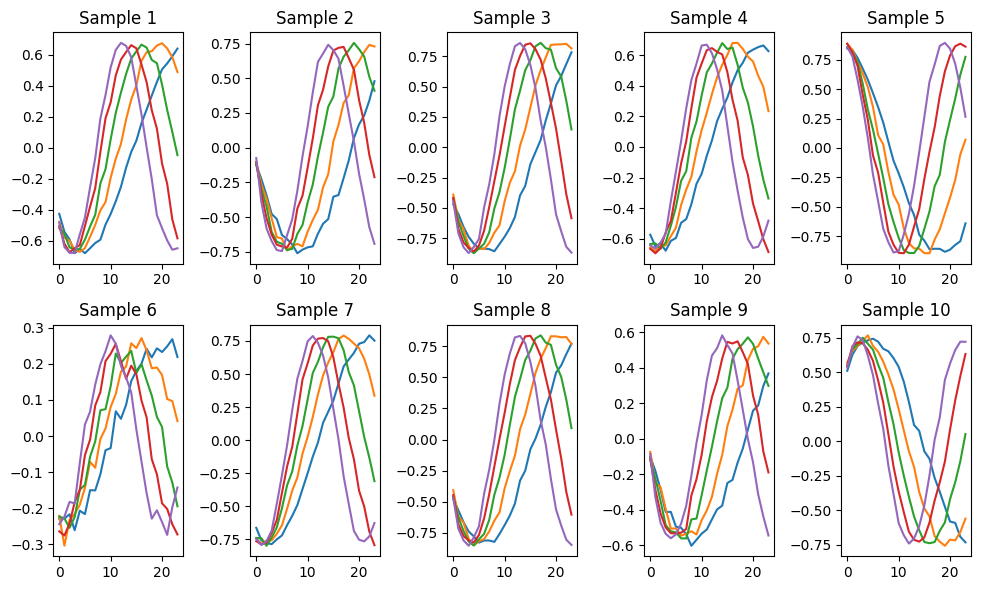

In [28]:
# Plot the GAN-generated samples
plt.figure(figsize=(10, 6))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.plot(generated_samples[i].reshape(n_ts, n_features))
    plt.title(f'Sample {i+1}')
plt.tight_layout()
plt.show()

##Using Hybrid model (VAE and GAN)

2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 4ms/step
Epoch 0, D Loss: 0.7040690779685974, G Loss: 0.3274965286254883, VAE Loss: 15.443203926086426
2/2 [==============================] - 0s 8ms/step
Epoch 10, D Loss: 0.3440781533718109, G Loss: 0.8660611510276794, VAE Loss: 0.13635368645191193
2/2 [==============================] - 0s 6ms/step
Epoch 20, D Loss: 0.2836446464061737, G Loss: 1.0540281534194946, VAE Loss: 0.06343881040811539
2/2 [==============================] - 0s 5ms/step
Epoch 30, D Loss: 0.22289738059043884, G Loss: 1.1774024963378906, VAE Loss: 0.025921709835529327
2/2 [==============================] - 0s 8ms/step
Epoch 40, D Loss: 0.20748133957386017, G Loss: 1.467614769935608, VAE Loss: 0.01961601711809635
2/2 [==============================] - 0s 5ms/step
Epoch 50, D Loss: 0.15005263686180115, G Loss: 1.6715023517608643, VAE Loss: 0.01097865216434002
2/2 [==============================] - 0s 6ms/step
Epoch 60, D Loss: 0.14066895842552185, G Loss: 1.7498046159744263,

ValueError: ignored

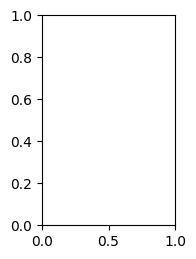

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Reshape, Flatten, Input, Lambda
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.losses import mean_squared_error, binary_crossentropy
from keras import backend as K

# Define the dimensions
n, n_ts, n_features = 1000, 24, 5

# Generate synthetic data
data = tsgm.utils.gen_sine_dataset(n, n_ts, n_features)

# Define the GAN architecture
def build_generator():
    generator = Sequential()
    generator.add(Dense(128, input_dim=100, activation='relu'))
    generator.add(Dense(n_ts * n_features, activation='tanh'))
    generator.add(Reshape((n_ts, n_features)))
    return generator

def build_discriminator():
    discriminator = Sequential()
    discriminator.add(Flatten(input_shape=(n_ts, n_features)))
    discriminator.add(Dense(128, activation='relu'))
    discriminator.add(Dense(1, activation='sigmoid'))
    return discriminator

generator = build_generator()
discriminator = build_discriminator()

# Define the VAE architecture
def build_vae(input_dim, latent_dim):
    inputs = Input(shape=input_dim)
    x = Dense(32, activation='relu')(inputs)
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling)([z_mean, z_log_var])

    decoder_input = Input(shape=(latent_dim,))
    decoder_output = Dense(32, activation='relu')(decoder_input)
    decoder_output = Dense(input_dim)(decoder_output)

    encoder = Model(inputs, z)
    decoder = Model(decoder_input, decoder_output)
    vae_output = decoder(encoder(inputs))

    vae = Model(inputs, vae_output)
    return vae, encoder, decoder

vae, vae_encoder, vae_decoder = build_vae(input_dim=n_ts * n_features, latent_dim=100)

# Compile the VAE and GAN models
vae.compile(optimizer='adam', loss=mean_squared_error)
discriminator.compile(loss=binary_crossentropy, optimizer=Adam(0.0002, 0.5))
discriminator.trainable = False

gan_input = Input(shape=(100,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(gan_input, gan_output)
gan.compile(loss=binary_crossentropy, optimizer=Adam(0.0002, 0.5))

# Train the hybrid model
batch_size = 64
epochs = 100

for e in range(epochs):
    for _ in range(n // batch_size):
        noise = np.random.normal(0, 1, size=[batch_size, 100])
        generated_data = generator.predict(noise)
        real_data = data[np.random.randint(0, data.shape[0], batch_size)]
        data_batch = np.concatenate([real_data, generated_data])
        labels = np.zeros(2 * batch_size)
        labels[:batch_size] = 1

        d_loss = discriminator.train_on_batch(data_batch, labels)

        noise = np.random.normal(0, 1, size=[batch_size, 100])
        labels = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, labels)

        real_data_flat = real_data.reshape(batch_size, -1)  # Flatten the real data for VAE
        vae_loss = vae.train_on_batch(real_data_flat, real_data_flat)

    if e % 10 == 0:
        print(f"Epoch {e}, D Loss: {d_loss}, G Loss: {g_loss}, VAE Loss: {vae_loss}")

# Generate samples using the VAE part of the hybrid model
vae_samples = vae_encoder.predict(data[:10].reshape(10, -1))  # Flatten input

# Generate samples using the GAN part of the hybrid model
noise = np.random.normal(0, 1, size=[10, 100])
gan_samples = generator.predict(noise)

In [ ]:
# Plot the VAE-generated samples
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.plot(vae_samples[i].reshape(n_ts, n_features))
    plt.title(f'VAE Sample {i+1}')
plt.tight_layout()

# Plot the GAN-generated samples
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.plot(gan_samples[i].reshape(n_ts, n_features))
    plt.title(f'GAN Sample {i+1}')
plt.tight_layout()

plt.show()